# Trends: Opportunity Youth Status by Age

SOURCE: 2017 5-year American Community Survey [(ACS)](https://www.census.gov/programs-surveys/acs/about.html) Public Use Microdata Survey [(PUMS)](https://www.census.gov/programs-surveys/acs/technical-documentation/pums.html).

## TASKS

* An update of the table “Opportunity Youth Status by Age” from 2016 report “Opportunity Youth in the Road Map Project Region” shown below

![alt text](2014OY_Age.png)

* A visualization that highlights a trend between the 2016 report and current data.

## PURPOSE

The purpose of this notebook is to collect the pertinent data from the database to update the Opportunity Youth by Age table, which was created with data from 2014. From there we will create a visualization that shows the trends and takeaways from this analysis.

## DEFINITIONS
* Definition of opportunity youth (16-to 24-year-olds not in school and not working)
* South King County includes pumas 11610 to 11615
* Throughout the notebook "Opportunity Youth" may be abbreviated as "OY"

## PLAN

  *  Import required Libraries and database
  *  Select required columns for analysis with SQL
  *  Clean dataset using SQL and Pandas
  *  Store the required data into accessible variables
  *  Display a table with the updated data
  *  Visualize the findings and identify any trends
  
#### COLUMNS OF NOTE
- puma - Area code (PUMA) based on 2010 Census definition (areas with population of 100,000 or more, use with ST for unique code)00100..70301.Public use microdata area codes
- agep - age
- sch - School enrollment
- schl - Educational attainment
- esr - Employment status recode
- pwgtp - Weight

## IMPORTING

In [49]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
DBNAME = "opportunity_youth"
conn = psycopg2.connect(dbname=DBNAME)

## FUNCTIONS
These functions support the data cleaning, collection and analysis of the data.

### Calculate Percentages

In [51]:
def calc_percent (one, two, three, arg_sum, tot1, tot2, tot3, tot_sum):
    per_list = []
    per1 = (one/tot1)*100
    per_list.append(round(per1))
    per2 = (two/tot2)*100
    per_list.append(round(per2))
    per3 = (three/tot3)*100
    per_list.append(round(per3))
    tot_per = (arg_sum/tot_sum)*100
    per_list.append(round(tot_per))
    return per_list
    

### Creating the Visualization

In [55]:
def plot_clustered_stacked(dfall, labels=None, title=""):

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    new_figure = plt.figure(figsize=(12,8))
    axe = new_figure.add_subplot(111)
    N=3
    ind = np.arange(N)
    new_figure.suptitle('Opportunity Youth Education by Age Group', fontname="Arial Black", fontsize=36,fontweight='bold')
    
    for df in dfall:
        totals = [i+j+k+l for i,j,k,l in zip(df['No diploma'], df['HS diploma or GED'], df['Some college, no degree'], df['Degree, Associate or higher'])]
        oyndBars = [i / j * 100 for i,j in zip(df['No diploma'], totals)]
        oydGEDBars = [i / j * 100 for i,j in zip(df['HS diploma or GED'], totals)]
        oyscndBars = [i / j * 100 for i,j in zip(df['Some college, no degree'], totals)]
        oydegBars = [i / j * 100 for i,j in zip(df['Degree, Associate or higher'], totals)]
        # names = list(age_grps)
        barWidth = 0.35 
        # No diploma bar
        axe.bar(ind, oyndBars, color='#1D3557', edgecolor='black', width=barWidth)
        # HS diploma bar
        axe.bar(ind, oydGEDBars, bottom=oyndBars, color='#A8DADC', edgecolor='black', width=barWidth)
        # Some college bar
        axe.bar(ind, oyscndBars, bottom=[i+j for i,j in zip(oyndBars, oydGEDBars)], color='#457B9D', edgecolor='black', width=barWidth)
        # Degree bar
        axe.bar(ind, oydegBars, bottom=[i+j+k for i,j,k in zip(oyndBars, oydGEDBars, oyscndBars)], color='#F1FAEE', edgecolor='black', width=barWidth)
        ind=ind + barWidth

    leg_labels = ['No diploma','HS diploma or GED', 'Some college, no degree', 'Degree, Associate or higher']
    axe.legend(leg_labels,loc=2)
        
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title,fontsize=16)

    # Add invisible data to add another legend
    n=[]
    colorBar=['#1D3557','#A8DADC','#457B9D','#F1FAEE']
    for i in range(0,4):
        n.append(axe.bar(0, 0, color=colorBar[i]))
        l2 = plt.legend(n, leg_labels, bbox_to_anchor=(1.0, 0.5, 0.3, 0.2),loc=2, fontsize=14,labelspacing=-2.5,frameon=False) 
    axe.set_ylim(0,100)
    axe.set_xticklabels(names,fontsize=18)
    axe.set_xlabel("Age Groups",fontsize=20,fontweight='bold')
    axe.set_ylabel("% of Opportunity Youth",fontsize=20,fontweight='bold')
    axe.text(-0.07, 101, "2014", fontsize=16)
    axe.text(0.25, 101, "2017", fontsize=16)
    axe.text(0.925, 101, "2014", fontsize=16)
    axe.text(1.25, 101, "2017", fontsize=16)
    axe.text(1.925, 101, "2014", fontsize=16)
    axe.text(2.25, 101, "2017", fontsize=16)
    return axe


## DATA CLEANING DATAFRAME CREATION

Given the definition of opportunity youth and the data needed for the table we will need to filter the data as follows: 
1. Isolate South King County data (PUMA) 
2. Split the data into the required age groups (agep) 
3. Identify the Opportunity Youth within that dataset (sch and esr) 
4. Breakdown the educational background of the Opportunity Youth (schl) 
5. Use the weight column (pwgtp) to get the estimated # of people for each category in the table. 


### General Exploration

We would like to first understand what the data looks like in the columns of note

In [50]:
df = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND agep >= 16.0
    AND agep <= 18.0
    ORDER BY agep
    """
, conn)
df.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,16.0,2,13,3,2,6,16.0,11611
1,16.0,2,12,3,2,6,29.0,11610
2,16.0,2,12,3,2,6,4.0,11614
3,16.0,2,12,2,None,6,25.0,11610
4,16.0,2,12,2,2,6,18.0,11611


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   agep    1054 non-null   float64
 1   sch     1054 non-null   object 
 2   schl    1054 non-null   object 
 3   wkl     1054 non-null   object 
 4   wrk     931 non-null    object 
 5   esr     1054 non-null   object 
 6   pwgtp   1054 non-null   float64
 7   puma    1054 non-null   object 
dtypes: float64(2), object(6)
memory usage: 66.0+ KB


### Filter Data by Age Group and Location
We need to split the data up by South King County and the age groups identified in the table: 16-18, 19-21, and 22-24. 

#### 16-18

In [5]:
# 16-18
df1 = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND agep >= 16.0
    AND agep <= 18.0
    ORDER BY agep
    """
, conn)
df1.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,16.0,3,11,3,None,6,12.0,11613
1,16.0,2,13,3,2,6,3.0,11614
2,16.0,3,12,1,1,1,22.0,11610
3,16.0,2,13,3,2,3,27.0,11614
4,16.0,2,13,3,2,6,18.0,11610


#### 19-21

In [6]:
# 19-21
df2 = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND agep >= 19.0
    AND agep <= 21.0
    ORDER BY agep
    """
, conn)
df2.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,19.0,2,18,3,2,6,30.0,11612
1,19.0,2,19,3,2,6,91.0,11614
2,19.0,1,17,1,2,6,11.0,11611
3,19.0,2,15,3,2,6,24.0,11614
4,19.0,2,19,1,1,1,13.0,11611


#### 22-24

In [7]:
# 22-24
df3 = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND agep >= 22.0
    AND agep <= 24.0
    ORDER BY agep
    """
, conn)
df3.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,22.0,1,16,1,1,1,22.0,11614
1,22.0,2,19,3,2,6,81.0,11614
2,22.0,1,16,1,2,3,15.0,11611
3,22.0,1,19,1,1,1,40.0,11613
4,22.0,2,19,1,None,1,12.0,11610


### General Population Totals for Updated Table
We need to sum the populations of the age groups to get the total population for the last column of the table.

In [8]:
# Population of 16-18yo
pop1 = df1.pwgtp.sum(axis = 0, skipna = True) 
# Population of 19-21yo
pop2 = df2.pwgtp.sum(axis = 0, skipna = True) 
# Population of 22-24yo
pop3 = df3.pwgtp.sum(axis = 0, skipna = True) 
# Total Populatio 16-24yo
total_pop = pop1 + pop2 + pop3
print("Population of 16-18yo: {}".format(pop1))
print("Population of 19-21yo: {}".format(pop2))
print("Population of 22-24yo: {}".format(pop3))
print("TOTAL: {}".format(total_pop))

Population of 16-18yo: 25131.0
Population of 19-21yo: 21586.0
Population of 22-24yo: 27231.0
TOTAL: 73948.0


### School Enrollment
* Opportunity Youth are not in school unemployed or not in the labor force
* sch will tell us if the youth in our age categories are in school
* We can create a dataframe of those not in school for each age group

In [9]:
# 16-18 not in school
df1_nsch = df1.loc[df1.sch == '1']
# 19-21 not in school
df2_nsch = df2.loc[df2.sch == '1']
# 22-24 not in school
df3_nsch = df3.loc[df3.sch == '1']

### Find Number of Opportunity Youth
- Opportunity Youth are not in school and are unemployed or not in the labor force

#### Filter School Enrollment dataFrames by Employment Status (esr) 
Using the dataframes of people those not in school for each age group we can identify the Opportunity Youth by isolating categories 3 and 6 from the esr column. 

- esr - Employment status recode 
- 1.Civilian employed, at work 
- 2.Civilian employed, with a job but not at work 
- 3.Unemployed 
- 4.Armed forces, at work 
- 5.Armed forces, with a job but not at work 
- 6.Not in labor force

In [10]:
def oy_pop (df_arg):
    df_oy = df_arg.groupby(['esr']).sum()
    oy = df_oy.at['3','pwgtp'] + df_oy.at['6','pwgtp']
    return oy

oy1 = oy_pop(df1_nsch)
oy2 = oy_pop(df2_nsch)
oy3 = oy_pop(df3_nsch)
total_oy = oy1 + oy2 + oy3

print("Opportunity Youth 16-18yo: {}".format(oy1))
print("Opportunity Youth 19-21yo: {}".format(oy2))
print("Opportunity Youth 22-24yo: {}".format(oy3))
print("TOTAL: {}".format(total_oy))

Opportunity Youth 16-18yo: 1739.0
Opportunity Youth 19-21yo: 3222.0
Opportunity Youth 22-24yo: 4443.0
TOTAL: 9404.0


### Working Without Diploma

Need to find those working without a diploma within each age group for the table.

#### Make dataframes that filter out people with diplomas (schl)
- schl 01 to 15 is the subset without a diploma

schl details: Educational attainmentbb. N/A (less than 3 years old)01.No schooling completed 02.Nursery school, preschool 03.Kindergarten 04.Grade 1 05.Grade 2 06.Grade 3 07.Grade 4 08.Grade 5 09.Grade 6 10.Grade 7 11.Grade 8 12.Grade 9 13.Grade 10 14.Grade 11 15.12th grade -no diploma 16.Regular high school diploma 17.GED or alternative credential 18.Some college, but less than 1 year 19.1 or more years of college credit, no degree 20.Associate's degree 21.Bachelor's degree 22.Master's degree 23.Professional degree beyond a bachelor's degree 24.Doctorate degree

In [12]:
# 16-18
df1_schl = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('01','02','03','04','05','06','07','08','09','10','11','12','13','14','15')
    AND sch = '1'
    AND agep >= 16.0
    AND agep <= 18.0
    ORDER BY agep
    """
, conn)
df1_schl.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,16.0,1,13,2,2,3,4.0,11614
1,16.0,1,13,3,2,6,22.0,11614
2,16.0,1,12,3,2,6,21.0,11613
3,16.0,1,12,1,None,1,17.0,11613
4,16.0,1,01,3,2,6,12.0,11611


In [13]:
# 19-21
df2_schl = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('01','02','03','04','05','06','07','08','09','10','11','12','13','14','15')
    AND sch = '1'
    AND agep >= 19.0
    AND agep <= 21.0
    ORDER BY agep
    """
, conn)
df2_schl.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,19.0,1,14,1,2,3,21.0,11613
1,19.0,1,15,1,1,1,10.0,11612
2,19.0,1,15,3,2,3,2.0,11614
3,19.0,1,13,1,2,3,40.0,11614
4,19.0,1,13,1,1,1,71.0,11613


In [14]:
# 22-24
df3_schl = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('01','02','03','04','05','06','07','08','09','10','11','12','13','14','15')
    AND sch = '1'
    AND agep >= 22.0
    AND agep <= 24.0
    ORDER BY agep
    """
, conn)
df3_schl.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,22.0,1,14,1,1,1,47.0,11613
1,22.0,1,05,1,2,6,130.0,11610
2,22.0,1,01,1,2,2,20.0,11612
3,22.0,1,15,1,1,1,44.0,11610
4,22.0,1,14,1,1,1,3.0,11614


In [53]:
# Function that sums the pwgtp for people working (esr = 1,2,4 and 5) without diplomas
# Does not work in it's current state because each category is made up of a different collection of responses.
def wwd_sum (df_arg):
    df_wwd = df_arg.groupby(['esr']).sum()
    wwd = df_wwd.at['1','pwgtp'] + df_wwd.at['2','pwgtp'] + df_wwd.at['4','pwgtp']+df_wwd.at['5','pwgtp']
    return wwd

df1_wwd = df1_schl.groupby(['esr']).sum()
df2_wwd = df2_schl.groupby(['esr']).sum()
df3_wwd = df3_schl.groupby(['esr']).sum()

wwd1 = df1_wwd.at['1','pwgtp']
wwd2 = df2_wwd.at['1','pwgtp'] + df2_wwd.at['2','pwgtp']
wwd3 = df3_wwd.at['1','pwgtp'] + df3_wwd.at['2','pwgtp'] + df3_wwd.at['4','pwgtp']
# wwd1 = wwd_sum(df1_schl)
# wwd2 = wwd_sum(df2_schl)
# wwd3 = wwd_sum(df3_schl)
total_wwd = wwd1 + wwd2 + wwd3

print("Working without diploma 16-18yo: {}".format(wwd1))
print("Working without diploma 19-21yo: {}".format(wwd2))
print("Working without diploma 22-24yo: {}".format(wwd3))
print("TOTAL: {}".format(total_wwd))

Working without diploma 16-18yo: 356.0
Working without diploma 19-21yo: 1237.0
Working without diploma 22-24yo: 1570.0
TOTAL: 3163.0


### Population that is not Opportunity Youth
Need to find the number of people not considered opportunity youth for each age group to populate the table.
- Take the difference of the population and opportunity youth

In [17]:
not_oy1= pop1 - oy1 - wwd1
not_oy2= pop2 - oy2 - wwd2
not_oy3= pop3 - oy3 - wwd3
total_not_oy = not_oy1 + not_oy2 + not_oy3

print("Not an Opportunity Youth 16-18yo: {}".format(not_oy1))
print("Not an Opportunity Youth 19-21yo: {}".format(not_oy2))
print("Not an Opportunity Youth 22-24yo: {}".format(not_oy3))
print("TOTAL: {}".format(total_not_oy))

Not an Opportunity Youth 16-18yo: 23036.0
Not an Opportunity Youth 19-21yo: 17127.0
Not an Opportunity Youth 22-24yo: 21218.0
TOTAL: 61381.0


### OY with no diploma
Within the Opportunity Youth data, we need to breakdown how many don't have a diploma

In [18]:
oynd1 = oy_pop(df1_schl)
oynd2 = oy_pop(df2_schl)
oynd3 = oy_pop(df3_schl)
total_oynd = oynd1 + oynd2 + oynd3

print("OY no diploma 16-18yo: {}".format(oynd1))
print("OY no diploma 19-21yo: {}".format(oynd2))
print("OY no diploma 22-24yo: {}".format(oynd3))
print("TOTAL: {}".format(total_oynd))

OY no diploma 16-18yo: 883.0
OY no diploma 19-21yo: 933.0
OY no diploma 22-24yo: 1275.0
TOTAL: 3091.0


### OY with diploma or GED
Within the Opportunity Youth data, we need to breakdown how many have a High School diploma or GED using schl

- schl = 16 or 17:

schl details: Educational attainmentbb. N/A (less than 3 years old)01.No schooling completed 02.Nursery school, preschool 03.Kindergarten 04.Grade 1 05.Grade 2 06.Grade 3 07.Grade 4 08.Grade 5 09.Grade 6 10.Grade 7 11.Grade 8 12.Grade 9 13.Grade 10 14.Grade 11 15.12th grade -no diploma 16.Regular high school diploma 17.GED or alternative credential 18.Some college, but less than 1 year 19.1 or more years of college credit, no degree 20.Associate's degree 21.Bachelor's degree 22.Master's degree 23.Professional degree beyond a bachelor's degree 24.Doctorate degree

In [20]:
# 16-18
df1_dGED = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('16','17')
    AND sch = '1'
    AND agep >= 16.0
    AND agep <= 18.0
    ORDER BY agep
    """
, conn)
df1_dGED.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,16.0,1,17,3,2,6,12.0,11614
1,17.0,1,17,3,2,6,13.0,11613
2,17.0,1,16,3,2,6,79.0,11612
3,17.0,1,16,1,1,1,21.0,11612
4,18.0,1,17,3,2,3,45.0,11611


In [21]:
# 19-21
df2_dGED = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('16','17')
    AND sch = '1'
    AND agep >= 19.0
    AND agep <= 21.0
    ORDER BY agep
    """
, conn)
df2_dGED.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,19.0,1,16,1,1,1,15.0,11610
1,19.0,1,16,1,1,1,18.0,11614
2,19.0,1,16,1,1,1,16.0,11610
3,19.0,1,16,3,2,6,20.0,11612
4,19.0,1,16,1,1,1,22.0,11614


In [22]:
# 22-24
df3_dGED = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('16','17')
    AND sch = '1'
    AND agep >= 22.0
    AND agep <= 24.0
    ORDER BY agep
    """
, conn)
df3_dGED.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,22.0,1,16,1,2,3,14.0,11610
1,22.0,1,17,1,2,3,19.0,11610
2,22.0,1,17,3,2,6,32.0,11612
3,22.0,1,17,2,2,6,2.0,11614
4,22.0,1,16,1,None,1,30.0,11611


In [23]:
oydGED1 = oy_pop(df1_dGED)
oydGED2 = oy_pop(df2_dGED)
oydGED3 = oy_pop(df3_dGED)
total_oydGED = oydGED1 + oydGED2 + oydGED3

print("OY with HS diploma or GED 16-18yo: {}".format(oydGED1))
print("OY with HS diploma or GED 19-21yo: {}".format(oydGED2))
print("OY with HS diploma or GED 22-24yo: {}".format(oydGED3))
print("TOTAL: {}".format(total_oydGED))

OY with HS diploma or GED 16-18yo: 738.0
OY with HS diploma or GED 19-21yo: 1761.0
OY with HS diploma or GED 22-24yo: 1914.0
TOTAL: 4413.0


### OY with some college, no degree
Now we use schl responses of 18 and 19 to find those with some college but no degree

schl details: Educational attainmentbb. N/A (less than 3 years old)01.No schooling completed 02.Nursery school, preschool 03.Kindergarten 04.Grade 1 05.Grade 2 06.Grade 3 07.Grade 4 08.Grade 5 09.Grade 6 10.Grade 7 11.Grade 8 12.Grade 9 13.Grade 10 14.Grade 11 15.12th grade -no diploma 16.Regular high school diploma 17.GED or alternative credential 18.Some college, but less than 1 year 19.1 or more years of college credit, no degree 20.Associate's degree 21.Bachelor's degree 22.Master's degree 23.Professional degree beyond a bachelor's degree 24.Doctorate degree

In [24]:
# 16-18
df1_scnd = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('18','19')
    AND sch = '1'
    AND agep >= 16.0
    AND agep <= 18.0
    ORDER BY agep
    """
, conn)
df1_scnd.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,16.0,1,19,1,1,1,6.0,11611
1,18.0,1,19,3,None,6,19.0,11612
2,18.0,1,19,1,1,1,16.0,11612
3,18.0,1,18,1,2,3,99.0,11610
4,18.0,1,19,1,1,1,18.0,11610


In [25]:
# 19-21
df2_scnd = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('18','19')
    AND sch = '1'
    AND agep >= 19.0
    AND agep <= 21.0
    ORDER BY agep
    """
, conn)
df2_scnd.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,19.0,1,19,2,2,3,26.0,11614
1,19.0,1,18,1,1,1,12.0,11611
2,19.0,1,18,3,2,6,49.0,11611
3,19.0,1,19,1,1,1,14.0,11613
4,19.0,1,19,1,1,1,13.0,11613


In [26]:
# 22-24
df3_scnd = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('18','19')
    AND sch = '1'
    AND agep >= 22.0
    AND agep <= 24.0
    ORDER BY agep
    """
, conn)
df3_scnd.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma
0,22.0,1,18,3,None,6,24.0,11612
1,22.0,1,19,1,1,1,40.0,11613
2,22.0,1,18,1,None,1,26.0,11611
3,22.0,1,18,1,1,1,26.0,11612
4,22.0,1,19,1,1,1,18.0,11612


In [27]:
oyscnd1 = oy_pop(df1_scnd)
oyscnd2 = oy_pop(df2_scnd)
oyscnd3 = oy_pop(df3_scnd)
total_oyscnd = oyscnd1 + oyscnd2 + oyscnd3

print("OY some college no degree 16-18yo: {}".format(oyscnd1))
print("OY some college no degree 19-21yo: {}".format(oyscnd2))
print("OY some college no degree 22-24yo: {}".format(oyscnd3))
print("TOTAL: {}".format(total_oyscnd))

OY some college no degree 16-18yo: 118.0
OY some college no degree 19-21yo: 481.0
OY some college no degree 22-24yo: 894.0
TOTAL: 1493.0


### OY with degree (Associate or higher)
Now we use schl to identify Opportunity Youth who have a Associates degree or higher
- schl = 20 to 24

schl details: Educational attainmentbb. N/A (less than 3 years old)01.No schooling completed 02.Nursery school, preschool 03.Kindergarten 04.Grade 1 05.Grade 2 06.Grade 3 07.Grade 4 08.Grade 5 09.Grade 6 10.Grade 7 11.Grade 8 12.Grade 9 13.Grade 10 14.Grade 11 15.12th grade -no diploma 16.Regular high school diploma 17.GED or alternative credential 18.Some college, but less than 1 year 19.1 or more years of college credit, no degree 20.Associate's degree 21.Bachelor's degree 22.Master's degree 23.Professional degree beyond a bachelor's degree 24.Doctorate degree

In [29]:
# 16-18
df1_deg = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('20','21','22','23','24')
    AND sch = '1'
    AND agep >= 16.0
    AND agep <= 18.0
    ORDER BY agep
    """
, conn)
df1_deg.head()

,agep,sch,schl,wkl,wrk,esr,pwgtp,puma


In [30]:
# 19-21
df2_deg = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('20','21','22','23','24')
    AND sch = '1'
    AND agep >= 19.0
    AND agep <= 21.0
    ORDER BY agep
    """
, conn)
df2_deg.groupby(['esr']).sum()

,agep,pwgtp
esr,,
1,409.0,524.0
6,62.0,47.0


In [31]:
# 22-24
df3_deg = pd.read_sql(
    """
    SELECT agep, sch, schl, wkl, wrk, esr, pwgtp, puma
    FROM pums_2017
    WHERE puma IN ('11610','11611','11612','11613','11614')
    AND schl IN ('20','21','22','23','24')
    AND sch = '1'
    AND agep >= 22.0
    AND agep <= 24.0
    ORDER BY agep
    """
, conn)
df3_deg.groupby(['esr']).sum()

,agep,pwgtp
esr,,
1,4204.0,4538.0
2,22.0,14.0
3,118.0,111.0
6,211.0,249.0


In [32]:
df1_deg1 = df1_deg.groupby(['esr']).sum()
df2_deg2 = df2_deg.groupby(['esr']).sum()
df3_deg3 = df3_deg.groupby(['esr']).sum()


oydeg1 = 0
oydeg2 = df2_deg2.at['6','pwgtp']
oydeg3 = df3_deg3.at['3','pwgtp'] + df3_deg3.at['6','pwgtp']
total_oydeg = oydeg1 + oydeg2 + oydeg3

print("OY Degree 16-18yo: {}".format(oydeg1))
print("OY Degree 19-21yo: {}".format(oydeg2))
print("OY Degree 22-24yo: {}".format(oydeg3))
print("TOTAL: {}".format(total_oydeg))

OY Degree 16-18yo: 0
OY Degree 19-21yo: 47.0
OY Degree 22-24yo: 360.0
TOTAL: 407.0


### Table Data
- Collect all the table data in one place

In [34]:
print("Population of 16-18yo: {}".format(pop1))
print("Population of 19-21yo: {}".format(pop2))
print("Population of 22-24yo: {}".format(pop3))
print("TOTAL: {}".format(total_pop))
print("--------------------------------------------------------")
print("Opportunity Youth 16-18yo: {}".format(oy1))
print("Opportunity Youth 19-21yo: {}".format(oy2))
print("Opportunity Youth 22-24yo: {}".format(oy3))
print("TOTAL: {}".format(total_oy))
oy_percent = calc_percent(oy1,oy2,oy3,total_oy,pop1,pop2,pop3,total_pop)
print("OY % of population: {}".format(oy_percent))
print("--------------------------------------------------------")
print("Working without diploma 16-18yo: {}".format(wwd1))
print("Working without diploma 19-21yo: {}".format(wwd2))
print("Working without diploma 22-24yo: {}".format(wwd3))
print("TOTAL: {}".format(total_wwd))
wwd_percent = calc_percent(wwd1,wwd2,wwd3,total_wwd,pop1,pop2,pop3,total_pop)
print("WWD % of population: {}".format(wwd_percent))
print("--------------------------------------------------------")
print("Not an Opportunity Youth 16-18yo: {}".format(not_oy1))
print("Not an Opportunity Youth 19-21yo: {}".format(not_oy2))
print("Not an Opportunity Youth 22-24yo: {}".format(not_oy3))
print("TOTAL: {}".format(total_not_oy))
not_oy_percent = calc_percent(not_oy1,not_oy2,not_oy3,total_not_oy,pop1,pop2,pop3,total_pop)
print("Not OY % of population: {}".format(not_oy_percent))
print("--------------------------------------------------------")
print("OY no diploma 16-18yo: {}".format(oynd1))
print("OY no diploma 19-21yo: {}".format(oynd2))
print("OY no diploma 22-24yo: {}".format(oynd3))
print("TOTAL: {}".format(total_oynd))
oynd_percent = calc_percent(oynd1,oynd2,oynd3,total_oynd,oy1,oy2,oy3,total_oy)
print("OY no diploma % of OY: {}".format(oynd_percent))
print("--------------------------------------------------------")
print("OY with HS diploma or GED 16-18yo: {}".format(oydGED1))
print("OY with HS diploma or GED 19-21yo: {}".format(oydGED2))
print("OY with HS diploma or GED 22-24yo: {}".format(oydGED3))
print("TOTAL: {}".format(total_oydGED))
oydGED_percent = calc_percent(oydGED1,oydGED2,oydGED3,total_oydGED,oy1,oy2,oy3,total_oy)
print("OY HS diploma or GED % of OY: {}".format(oydGED_percent))
print("--------------------------------------------------------")
print("OY some college no degree 16-18yo: {}".format(oyscnd1))
print("OY some college no degree 19-21yo: {}".format(oyscnd2))
print("OY some college no degree 22-24yo: {}".format(oyscnd3))
print("TOTAL: {}".format(total_oyscnd))
oyscnd_percent = calc_percent(oyscnd1,oyscnd2,oyscnd3,total_oyscnd,oy1,oy2,oy3,total_oy)
print("OY some college no degree % of OY: {}".format(oyscnd_percent))
print("--------------------------------------------------------")
print("OY Degree 16-18yo: {}".format(oydeg1))
print("OY Degree 19-21yo: {}".format(oydeg2))
print("OY Degree 22-24yo: {}".format(oydeg3))
print("TOTAL: {}".format(total_oydeg))
oydeg_percent = calc_percent(oydeg1,oydeg2,oydeg3,total_oydeg,oy1,oy2,oy3,total_oy)
print("OY with degree % of OY: {}".format(oydeg_percent))

Population of 16-18yo: 25131.0
Population of 19-21yo: 21586.0
Population of 22-24yo: 27231.0
TOTAL: 73948.0
--------------------------------------------------------
Opportunity Youth 16-18yo: 1739.0
Opportunity Youth 19-21yo: 3222.0
Opportunity Youth 22-24yo: 4443.0
TOTAL: 9404.0
OY % of population: [7.0, 15.0, 16.0, 13.0]
--------------------------------------------------------
Working without diploma 16-18yo: 356.0
Working without diploma 19-21yo: 1237.0
Working without diploma 22-24yo: 1570.0
TOTAL: 3163.0
WWD % of population: [1.0, 6.0, 6.0, 4.0]
--------------------------------------------------------
Not an Opportunity Youth 16-18yo: 23036.0
Not an Opportunity Youth 19-21yo: 17127.0
Not an Opportunity Youth 22-24yo: 21218.0
TOTAL: 61381.0
Not OY % of population: [92.0, 79.0, 78.0, 83.0]
--------------------------------------------------------
OY no diploma 16-18yo: 883.0
OY no diploma 19-21yo: 933.0
OY no diploma 22-24yo: 1275.0
TOTAL: 3091.0
OY no diploma % of OY: [51.0, 29.0, 2

### Updated Table
This is the table with updated data from 2017.

![alt text](2017OY_Age.png)

## CREATING THE VISUALIZATION
We will create a stacked bar chart visualization to compare the data from 2014 with the current data in order to viually identify any trends. 

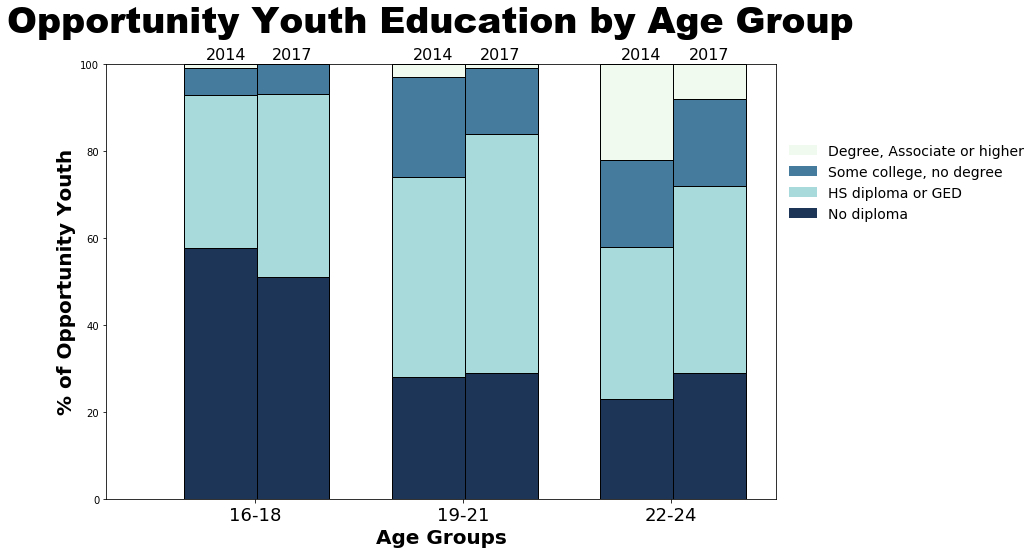

In [56]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# create dataframes
raw_data = {'No diploma': oynd_percent[:3], 'HS diploma or GED': oydGED_percent[:3],'Some college, no degree': oyscnd_percent[:3], 'Degree, Associate or higher':oydeg_percent[:3]}
df1 = pd.DataFrame(raw_data)
raw_data2 = {'No diploma': [57,28,23], 'HS diploma or GED': [35,46,35],'Some college, no degree': [6,23,20], 'Degree, Associate or higher':[1,3,22]}
df2 = pd.DataFrame(raw_data2) 

# Then call :
plot_clustered_stacked([df2, df1],["2017", "2014"]);

### Identifying any trends
We can see that within the 22-24 age group there was a significant dropoff in the number of degreed Opportunity Youth. This could mean that more grads are being hired into the workforce. However, when you look at the increase in the amount of OY in the 19-21 age group that have a HS diploma or GED, and the shrinking population of those with some college credits, we can deduce that less Youth are taking the next step in getting higher education. That seems to be the likely contributor for the dropoff. Further investigation can be done to confirm this by seeing if the general population in these regions has seen any changes in the percentage of people with higher education.

In [42]:
conn.close()